In [13]:
import os
import yaml
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path
from matplotlib.patches import Rectangle

from utils import *

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


In [14]:
with open('config_MM.yaml' ,'r') as file:
    config = yaml.safe_load(file)

ds_NCBI = pd.read_pickle('data/NCBI_all.pkl')
ds_TESSy = pd.read_pickle('data/TESSy_all.pkl')
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 0].copy()

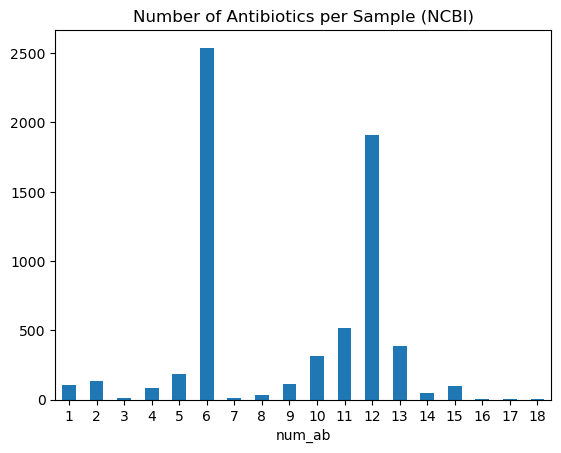

In [15]:
ds_MM['num_ab'].astype('int').value_counts().sort_index().plot(kind='bar', rot=0)
plt.title('Number of Antibiotics per Sample (NCBI)')
plt.show()

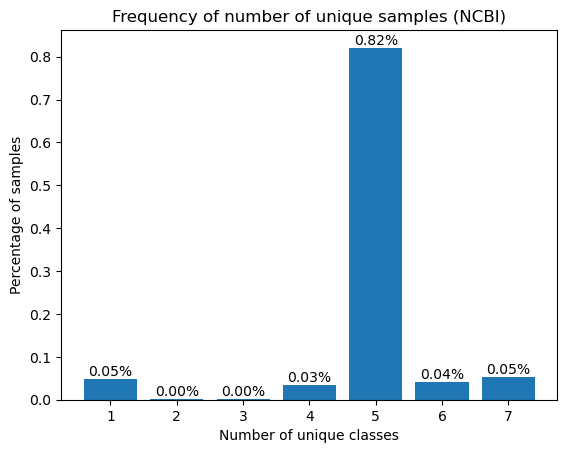

In [16]:
abbr_to_class_enc = config['data']['antibiotics']['abbr_to_class_enc']
ds_MM['ab_classes'] = ds_MM['phenotypes'].apply(lambda x: [abbr_to_class_enc[p.split('_')[0]] for p in x])
ds_MM['num_classes'] = ds_MM['ab_classes'].apply(lambda x: len(set(x)))
value_counts = ds_MM['num_classes'].value_counts(normalize=True).sort_index()
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values)
ax.bar_label(bars, fmt='%.2f%%')
ax.set_xlabel("Number of unique classes")
ax.set_ylabel("Percentage of samples")
plt.title('Frequency of number of unique samples (NCBI)')
plt.show()

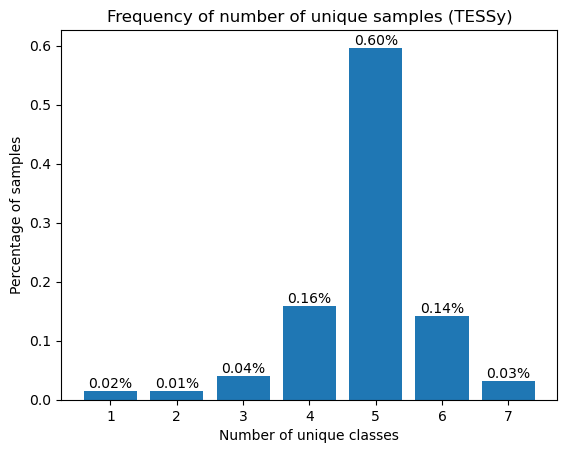

In [17]:
ds_TESSy['ab_classes'] = ds_TESSy['phenotypes'].apply(lambda x: [abbr_to_class_enc[p.split('_')[0]] for p in x])
ds_TESSy['num_classes'] = ds_TESSy['ab_classes'].apply(lambda x: len(set(x)))
value_counts = ds_TESSy['num_classes'].value_counts(normalize=True).sort_index()
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values)
ax.bar_label(bars, fmt='%.2f%%')
ax.set_xlabel("Number of unique classes")
ax.set_ylabel("Percentage of samples")
plt.title('Frequency of number of unique samples (TESSy)')
plt.show()

In [18]:
def get_pivot_from_processed_datasets(ds, colname = 'phenotypes'):
    df_pivot = ds[colname].explode().value_counts().reset_index()
    num_samples = ds[ds[colname].notna()].shape[0]
    df_pivot.columns = ['phenotype', 'count']
    df_pivot['Antibiotic'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[0])
    df_pivot['SR'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[1])
    df_pivot = df_pivot.drop(columns='phenotype').set_index('Antibiotic')
    df_pivot = df_pivot.pivot(columns='SR', values='count').fillna(0)
    df_pivot = df_pivot[['S', 'R']].astype(int).astype(object)
    df_pivot[['S_share', 'R_share']] = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot['Total'] = df_pivot['S'] + df_pivot['R']
    df_pivot['Frequency'] = df_pivot['Total'] / num_samples
    df_pivot = df_pivot[['Total', 'Frequency', 'S', 'R', 'S_share', 'R_share']]
    
    return df_pivot


def export_pivot_to_latex(
    pivot,
    savepath,
    axis_names=['Dataset', 'Antibiotic'],
    column_format='c|ccc|ccc',
    float_format="%.4f"
):
    df_latex = pivot.drop(columns=['Total', 'S', 'R'], level=1)
    # for ds in ['NCBI', 'TESSy']:
        # for col in ['S', 'R']:
            # df_latex[(ds, col)] = df_latex[(ds, col)].astype(str).apply(lambda x: f'{int(x):,}' if x.isnumeric() else '-')
    df_latex = df_latex.rename(columns={'S_share':r'$f_\text{S}$', 'R_share':r'$f_\text{R}$', 'Frequency':r'$f$'})
    df_latex.rename_axis(axis_names, axis=1, inplace=True)
    df_latex.to_latex(savepath, float_format=float_format, multicolumn_format='c', na_rep='-', column_format=column_format)

# Antibiotic imbalance

## Overall datasets

In [19]:
ds_TESSy = pd.read_pickle('data/TESSy_all.pkl')
ds_NCBI = pd.read_pickle('data/NCBI_all.pkl')

pivot_TESSy = get_pivot_from_processed_datasets(ds_TESSy)
num_TESSy_samples = ds_TESSy.shape[0]
pivot_NCBI = get_pivot_from_processed_datasets(ds_NCBI)
num_NCBI_samples = ds_NCBI.shape[0]
num_MM_samples = ds_MM.shape[0]

df_pivot = pd.concat([pivot_NCBI, pivot_TESSy], axis=1, keys=['NCBI', 'TESSy'], names=['Dataset', 'S/R'])
df_pivot

Dataset     NCBI                                              TESSy            \
S/R        Total Frequency     S     R   S_share   R_share    Total Frequency   
Antibiotic                                                                      
AMK         3285  0.505385  3236    49  0.985084  0.014916   716400  0.496586   
AMP         6122  0.941846  3277  2845  0.535283  0.464717   923116  0.639876   
AMX           34  0.005231     1    33  0.029412  0.970588   339826  0.235557   
CAZ         3355  0.516154  2402   953  0.715946  0.284054  1225411  0.849417   
CIP         6192  0.952615  5002  1190  0.807817  0.192183  1327086  0.919895   
COL          371  0.057077   358    13   0.96496   0.03504   104149  0.072193   
CRO         5838  0.898154  4713  1125  0.807297  0.192703   394256  0.273286   
CTX          844  0.129846   134   710  0.158768  0.841232  1106178  0.766769   
DOR          152  0.023385   114    38      0.75      0.25     2315  0.001605   
ETP         3224     0.496  3120   104  0.967742  0.032258   352826  0.244568   
FEP         3291  0.506308  2679   612  0.814038  0.185962   298871  0.207168   
GEN         6083  0.935846  5294   789  0.870294  0.129706  1245501  0.863343   
IPM         2848  0.438154  2787    61  0.978581  0.021419   734898  0.509409   
LVX         2861  0.440154  1995   866  0.697309  0.302691   273812  0.189798   
MEM         6040  0.929231  5962    78  0.987086  0.012914   968816  0.671554   
MFX           57  0.008769    19    38  0.333333  0.666667    92067  0.063818   
NAL         3340  0.513846  3111   229  0.931437  0.068563    61343  0.042521   
NET            1  0.000154     0     1       0.0       1.0    30564  0.021186   
NOR           91     0.014    76    15  0.835165  0.164835    20720  0.014362   
PIP            7  0.001077     1     6  0.142857  0.857143    76709  0.053172   
POL            3  0.000462     3     0       1.0       0.0     1739  0.001205   
TGC          615  0.094615   609     6  0.990244  0.009756   219492  0.152145   
TOB         2668  0.410462  2429   239   0.91042   0.08958   644996  0.447091   
AMC          NaN       NaN   NaN   NaN       NaN       NaN   497693  0.344986   
OFX          NaN       NaN   NaN   NaN       NaN       NaN   135108  0.093653   
TZP          NaN       NaN   NaN   NaN       NaN       NaN   595218  0.412587   

Dataset                                          
S/R               S       R   S_share   R_share  
Antibiotic                                       
AMK          708757    7643  0.989331  0.010669  
AMP          409186  513930  0.443266  0.556734  
AMX          156101  183725  0.459356  0.540644  
CAZ         1123675  101736  0.916978  0.083022  
CIP         1066212  260874  0.803423  0.196577  
COL          102992    1157  0.988891  0.011109  
CRO          358251   36005  0.908676  0.091324  
CTX          995114  111064  0.899597  0.100403  
DOR            2307       8  0.996544  0.003456  
ETP          351992     834  0.997636  0.002364  
FEP          270585   28286  0.905357  0.094643  
GEN         1145646   99855  0.919827  0.080173  
IPM          734413     485   0.99934   0.00066  
LVX          213028   60784  0.778008  0.221992  
MEM          968082     734  0.999242  0.000758  
MFX           68637   23430  0.745511  0.254489  
NAL           44950   16393  0.732765  0.267235  
NET           29152    1412  0.953802  0.046198  
NOR           15120    5600   0.72973   0.27027  
PIP           39018   37691   0.50865   0.49135  
POL            1724      15  0.991374  0.008626  
TGC          218418    1074  0.995107  0.004893  
TOB          590413   54583  0.915375  0.084625  
AMC          331779  165914  0.666634  0.333366  
OFX          111041   24067  0.821868  0.178132  
TZP          551183   44035  0.926019  0.073981

### Figures showing antibiotic distributions with ab prevalence in absolute numbers (two axes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


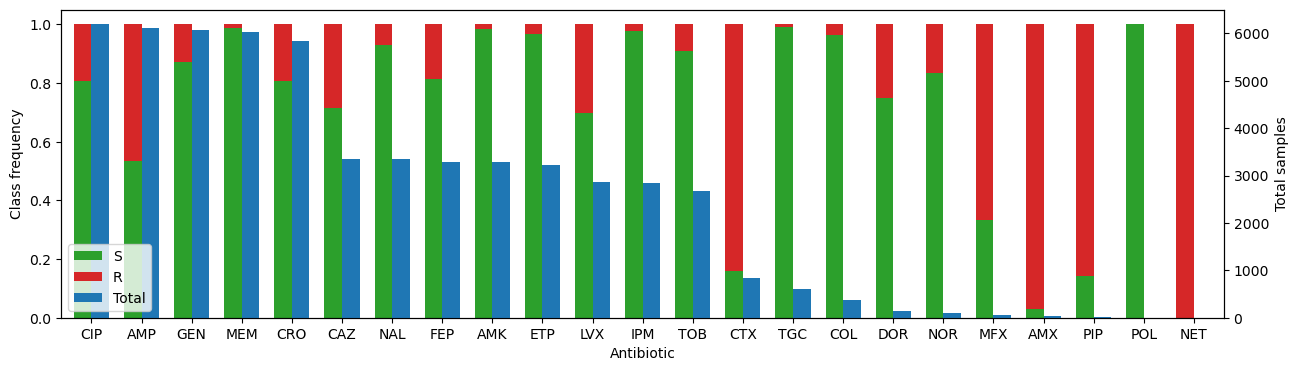

In [20]:
fig, ax = plt.subplots(figsize=(15, 4))
ax2 = ax.twinx()

pivot_NCBI.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.35    
pivot_NCBI[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_NCBI['Total'].plot(kind='bar', width=bar_width, color='tab:blue', ax=ax2, position=0, label='Total', legend=False)

ax.set_ylabel('Class frequency')
ax2.set_ylabel('Total samples')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_NCBI)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'NCBI_ab_distr_2ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


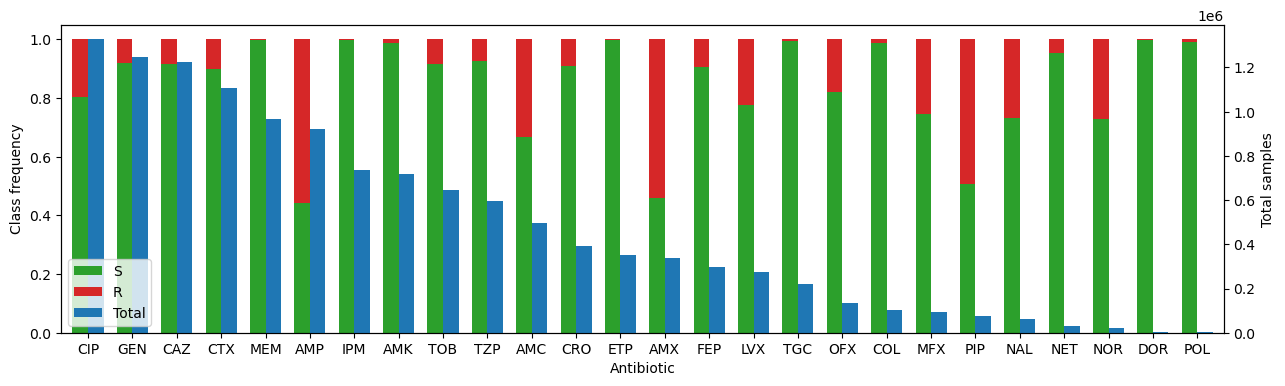

In [21]:
fig, ax = plt.subplots(figsize=(15, 4))
ax2 = ax.twinx()

pivot_TESSy.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.35    
pivot_TESSy[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_TESSy['Total'].plot(kind='bar', width=bar_width, color='tab:blue', ax=ax2, position=0, label='Total', legend=False)

ax.set_ylabel('Class frequency')
ax2.set_ylabel('Total samples')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_TESSy)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'TESSy_ab_distr_2ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

### Figures showing antibiotic distributions with ab prevalence as share of samples (one axis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


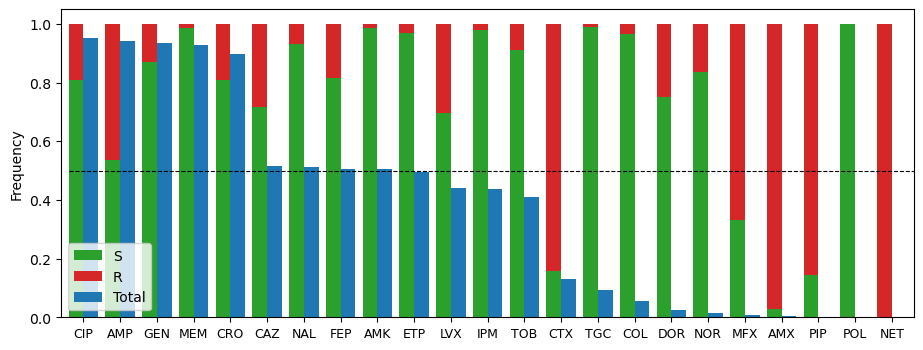

In [22]:
fig, ax = plt.subplots(figsize=(11, 4))

pivot_NCBI.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.4    
pivot_NCBI[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_NCBI['Total'].div(num_MM_samples).plot(kind='bar', width=bar_width, color='tab:blue', position=0, label='Total', rot=0, legend=False)    

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.plot(np.arange(-0.4, len(pivot_NCBI-0.4)), 0.5*np.ones(len(pivot_NCBI)+1), color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Frequency')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_NCBI)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'NCBI_ab_distr_1ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


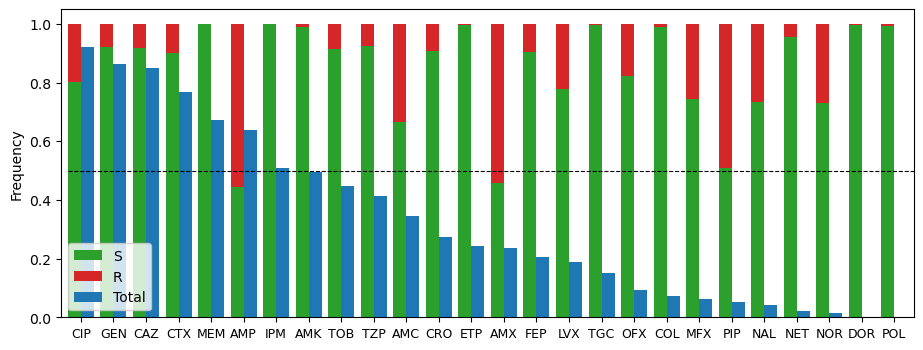

In [23]:
fig, ax = plt.subplots(figsize=(11, 4))

pivot_TESSy.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.4    
pivot_TESSy[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_TESSy['Total'].div(num_TESSy_samples).plot(kind='bar', width=bar_width, color='tab:blue', position=0, label='Total', rot=0, legend=False)    

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.plot(np.arange(-0.4, len(pivot_TESSy-0.4)), 0.5*np.ones(len(pivot_TESSy)+1), color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Frequency')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_TESSy)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'TESSy_ab_distr_1ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

### Table

In [24]:
abbr_to_class = config['data']['antibiotics']['abbr_to_class']
abbr_to_name = config['data']['antibiotics']['abbr_to_name']
df_pivot.to_csv('data/selected_antibiotics_pivot.csv')
export_pivot_to_latex(df_pivot, 'data/antibiotics_pivot.tex', float_format="%.4f", column_format='c|ccc|ccc')

## Selected antibiotics

In [25]:
def get_pivot_from_processed_datasets(ds, colname = 'phenotypes'):
    df_pivot = ds[colname].explode().value_counts().reset_index()
    num_samples = ds[ds[colname].notna()].shape[0]
    df_pivot.columns = ['phenotype', 'count']
    df_pivot['Antibiotic'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[0])
    df_pivot['SR'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[1])
    df_pivot = df_pivot.drop(columns='phenotype').set_index('Antibiotic')
    df_pivot = df_pivot.pivot(columns='SR', values='count').fillna(0)
    df_pivot = df_pivot[['S', 'R']].astype(int).astype(object)
    df_pivot[['S_share', 'R_share']] = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot['Total'] = df_pivot['S'] + df_pivot['R']
    df_pivot['Frequency'] = df_pivot['Total'] / num_samples
    df_pivot = df_pivot[['Total', 'Frequency', 'S', 'R', 'S_share', 'R_share']]
    
    return df_pivot

ds_TESSy = pd.read_pickle(config['data']['TESSy']['load_path'])
ds_NCBI = pd.read_pickle(config['data']['NCBI']['load_path'])

pivot_TESSy = get_pivot_from_processed_datasets(ds_TESSy)
num_TESSy_samples = ds_TESSy.shape[0]
pivot_NCBI = get_pivot_from_processed_datasets(ds_NCBI)
num_NCBI_samples = ds_NCBI.shape[0]
num_MM_samples = ds_MM.shape[0]

df_pivot = pd.concat([pivot_NCBI, pivot_TESSy], axis=1, keys=['NCBI', 'TESSy'], names=['Dataset', 'S/R'])
df_pivot

Dataset     NCBI                                              TESSy            \
S/R        Total Frequency     S     R   S_share   R_share    Total Frequency   
Antibiotic                                                                      
AMK         3285  0.505852  3236    49  0.985084  0.014916   716400  0.497204   
AMP         6122  0.942716  3277  2845  0.535283  0.464717   923116  0.640671   
CAZ         3355  0.516631  2402   953  0.715946  0.284054  1225411  0.850474   
CIP         6192  0.953496  5002  1190  0.807817  0.192183  1327086  0.921039   
CRO         5838  0.898984  4713  1125  0.807297  0.192703   394256  0.273626   
CTX          844  0.129966   134   710  0.158768  0.841232  1106178  0.767722   
ETP         3224  0.496458  3120   104  0.967742  0.032258   352826  0.244872   
FEP         3291  0.506775  2679   612  0.814038  0.185962   298871  0.207426   
GEN         6083  0.936711  5294   789  0.870294  0.129706  1245501  0.864417   
IPM         2848  0.438559  2787    61  0.978581  0.021419   734898  0.510042   
LVX         2861  0.440561  1995   866  0.697309  0.302691   273812  0.190034   
MEM         6040  0.930089  5962    78  0.987086  0.012914   968816  0.672389   
MFX           57  0.008777    19    38  0.333333  0.666667    92067  0.063897   
NAL         3340  0.514321  3111   229  0.931437  0.068563    61343  0.042574   
TOB         2668  0.410841  2429   239   0.91042   0.08958   644996  0.447647   

Dataset                                          
S/R               S       R   S_share   R_share  
Antibiotic                                       
AMK          708757    7643  0.989331  0.010669  
AMP          409186  513930  0.443266  0.556734  
CAZ         1123675  101736  0.916978  0.083022  
CIP         1066212  260874  0.803423  0.196577  
CRO          358251   36005  0.908676  0.091324  
CTX          995114  111064  0.899597  0.100403  
ETP          351992     834  0.997636  0.002364  
FEP          270585   28286  0.905357  0.094643  
GEN         1145646   99855  0.919827  0.080173  
IPM          734413     485   0.99934   0.00066  
LVX          213028   60784  0.778008  0.221992  
MEM          968082     734  0.999242  0.000758  
MFX           68637   23430  0.745511  0.254489  
NAL           44950   16393  0.732765  0.267235  
TOB          590413   54583  0.915375  0.084625

In [35]:
ds_TESSy[ds_TESSy['num_ab'] < 5].sample(frac=1).head(n=15)

,year,country,gender,age,phenotypes,num_ab,num_R,num_S
1387427,2018,UK,M,54.0,[CIP_R],1,1,0
846992,2019,Italy,M,81.0,"[CTX_S, CAZ_S, CIP_S, MEM_S]",4,0,4
1139443,2004,Sweden,F,77.0,"[CTX_S, CAZ_S, CIP_S, GEN_S]",4,0,4
1438384,2019,UK,F,78.0,[GEN_S],1,0,1
763840,2007,Ireland,M,69.0,"[AMP_S, CAZ_S, CIP_R, GEN_S]",4,1,3
1279218,2009,UK,M,84.0,[GEN_S],1,0,1
81564,2010,Belgium,F,77.0,[AMP_S],1,0,1
1191409,2015,Sweden,F,72.0,"[GEN_S, IPM_S]",2,0,2
534635,2015,Finland,M,75.0,[AMP_S],1,0,1
94040,2013,Belgium,F,86.0,"[CAZ_S, AMP_S, MEM_S, CTX_S]",4,0,4


In [34]:
ds_NCBI[ds_NCBI['num_genotypes'] < 3].sample(frac=1).head(n=15)

,year,country,genotypes,phenotypes,num_ab,num_genotypes,num_point_mutations
320476,2016,Belgium,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
121699,NaN,USA,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
283378,2022,UK,[glpT_E448K=POINT],NaN,0.0,1,1
118666,NaN,USA,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
33170,NaN,USA,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
179105,NaN,USA,"[gyrA_S83L=POINT, tet(A)]",NaN,0.0,2,1
55686,2018,UK,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
131141,2020,UK,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
282700,2009,USA,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2
55655,2018,UK,"[pmrB_Y358N=POINT, glpT_E448K=POINT]",NaN,0.0,2,2


In [50]:
ds_MM[(ds_MM['num_genotypes'] < 4) & (ds_MM['num_point_mutations'] < 1) & (ds_MM['num_ab'] < 5)].sample(frac=1).head(n=15)

,year,country,genotypes,phenotypes,num_ab,num_genotypes,num_point_mutations,ab_classes,num_classes
43167,2013,Germany,"[blaTEM-1, tet(A)]","[CIP_S, LVX_S, NAL_R, NOR_S]",4.0,2,0,"[3, 3, 3, 3]",1


### Figures showing antibiotic distributions with ab prevalence in absolute numbers (two axes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


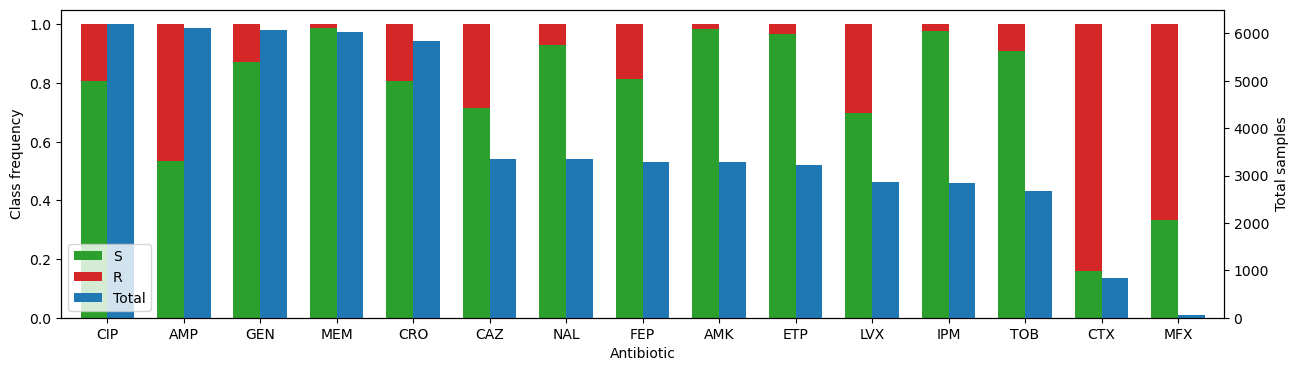

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax2 = ax.twinx()

pivot_NCBI.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.35    
pivot_NCBI[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_NCBI['Total'].plot(kind='bar', width=bar_width, color='tab:blue', ax=ax2, position=0, label='Total', legend=False)

ax.set_ylabel('Class frequency')
ax2.set_ylabel('Total samples')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_NCBI)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'NCBI_15_ab_distr_2ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


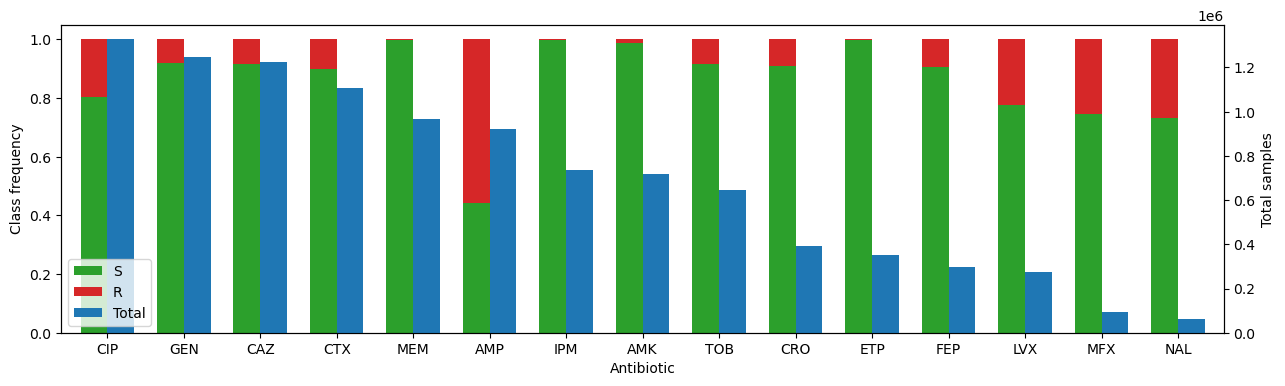

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax2 = ax.twinx()

pivot_TESSy.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.35    
pivot_TESSy[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_TESSy['Total'].plot(kind='bar', width=bar_width, color='tab:blue', ax=ax2, position=0, label='Total', legend=False)

ax.set_ylabel('Class frequency')
ax2.set_ylabel('Total samples')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_TESSy)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'TESSy_15_ab_distr_2ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

### Figures showing antibiotic distributions with ab prevalence as share of samples (one axis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


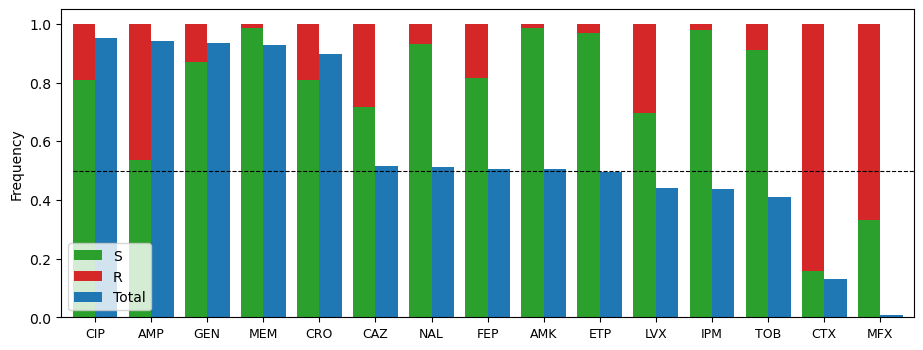

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))

pivot_NCBI.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.4    
pivot_NCBI[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_NCBI['Total'].div(num_MM_samples).plot(kind='bar', width=bar_width, color='tab:blue', position=0, label='Total', rot=0, legend=False)    

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.plot(np.arange(-0.4, len(pivot_NCBI-0.4)), 0.5*np.ones(len(pivot_NCBI)+1), color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Frequency')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_NCBI)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'NCBI_15_ab_distr_1ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


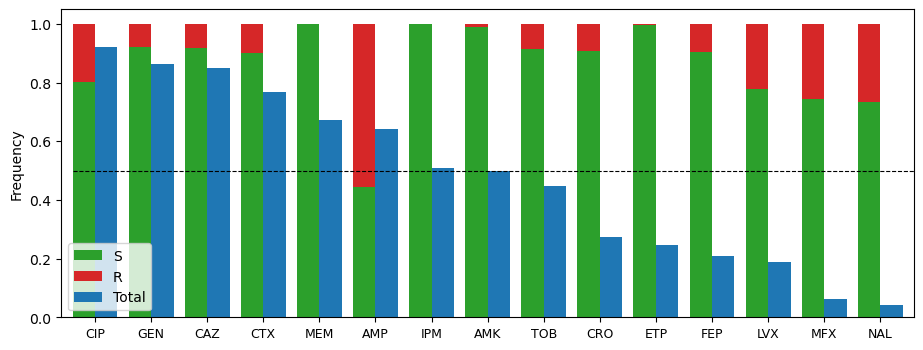

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))

pivot_TESSy.sort_values('Total', ascending=False, inplace=True)

bar_width = 0.4    
pivot_TESSy[['S_share', 'R_share']].plot(
    kind='bar', rot=0, width=bar_width, stacked=True, color=['tab:green', 'tab:red'], ax=ax, position=1, legend=False
)
pivot_TESSy['Total'].div(num_TESSy_samples).plot(kind='bar', width=bar_width, color='tab:blue', position=0, label='Total', rot=0, legend=False)    

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.plot(np.arange(-0.4, len(pivot_TESSy-0.4)), 0.5*np.ones(len(pivot_TESSy)+1), color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Frequency')
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.6, len(pivot_TESSy)-0.4)
tot = Rectangle((0,0),1,1,fc="tab:blue", edgecolor='none', linewidth=0)
s = Rectangle((0,0),1,1,fc="tab:green", edgecolor='none', linewidth=0)
r = Rectangle((0,0),1,1,fc="tab:red", edgecolor='none', linewidth=0)
plt.legend([s, r, tot], ['S', 'R', 'Total'], loc='lower left')
plt.savefig(os.path.join('results', 'figures', 'TESSy_15_ab_distr_1ax.eps'), bbox_inches='tight', dpi=300)
plt.show()

### Table

In [ ]:
abbr_to_class = config['data']['antibiotics']['abbr_to_class']
df_pivot.insert(0, '', df_pivot.index.map(abbr_to_class))
abbr_to_name = config['data']['antibiotics']['abbr_to_name']
df_pivot.index.name = 'Abbreviation'
df_pivot.insert(0,'Antibiotic', df_pivot.index.map(abbr_to_name))
df_pivot = df_pivot.reset_index(drop=False).set_index('Antibiotic')
df_pivot.to_csv('data/selected_antibiotics_pivot.csv')
export_pivot_to_latex(df_pivot, 'data/15_antibiotics_pivot.tex', float_format="%.3f", column_format='ccc|ccc|ccc')

## Geographical distributions for NCBI

Number of unique countries: 155
USA prevalence: 0.44
USA prevalence (MM): 0.86


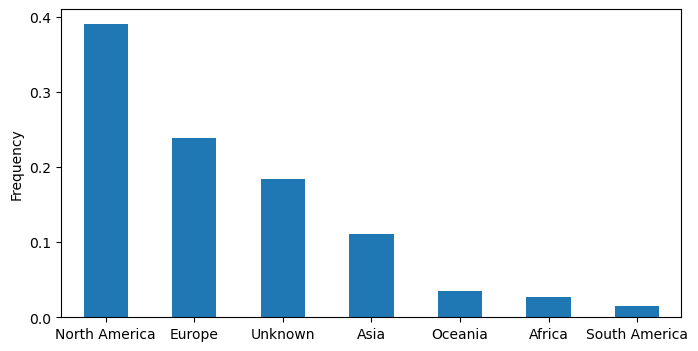

In [ ]:
region_mapping = config['data']['region_mapping']
regions = ds_NCBI['country'].map(region_mapping).replace({np.nan: 'Unknown'})
print(f"Number of unique countries: {ds_NCBI['country'].nunique()}")
print(f"USA prevalence: {ds_NCBI['country'].value_counts(normalize=True)['USA']:.2f}")
print(f"USA prevalence (MM): {ds_MM['country'].value_counts(normalize=True)['USA']:.2f}")

fig, ax = plt.subplots(figsize=(8, 4))
region_counts_normalized = regions.value_counts(dropna=False, normalize=True)
region_counts_normalized.plot(kind='bar', rot=0, ax=ax)
ax.set_ylabel('Frequency')
ax.set_xlabel('')
ax.set_yticks(np.arange(0, region_counts_normalized.max()+0.1, 0.1))
plt.savefig(os.path.join('results', 'figures', 'NCBI_region_distr.eps'), bbox_inches='tight', dpi=300)
plt.show()

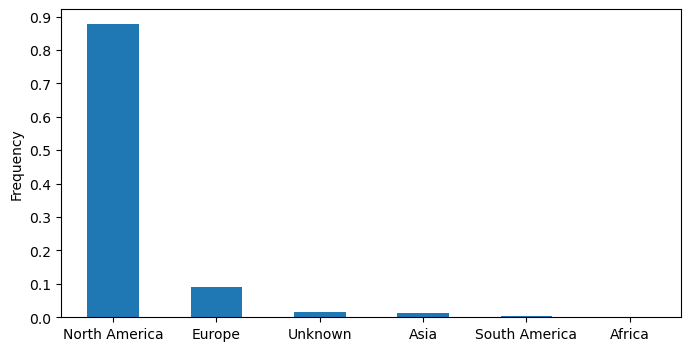

In [ ]:
region_mapping = config['data']['region_mapping']
regions = ds_MM['country'].map(region_mapping).replace({np.nan: 'Unknown'})

fig, ax = plt.subplots(figsize=(8, 4))
region_counts_normalized_MM = regions.value_counts(dropna=False, normalize=True)
region_counts_normalized_MM.plot(kind='bar', rot=0, ax=ax)
ax.set_ylabel('Frequency')
ax.set_xlabel('')
ax.set_yticks(np.arange(0, region_counts_normalized_MM.max()+0.1, 0.1))
plt.savefig(os.path.join('results', 'figures', 'NCBI_MM_region_distr.eps'), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
region_counts_normalized

country
North America    0.390200
Europe           0.237841
Unknown          0.184344
Asia             0.110717
Oceania          0.034986
Africa           0.027446
South America    0.014466
Name: proportion, dtype: float64

In [ ]:
region_counts_normalized_MM

country
North America    0.878000
Europe           0.091692
Unknown          0.014769
Asia             0.012615
South America    0.002462
Africa           0.000462
Name: proportion, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


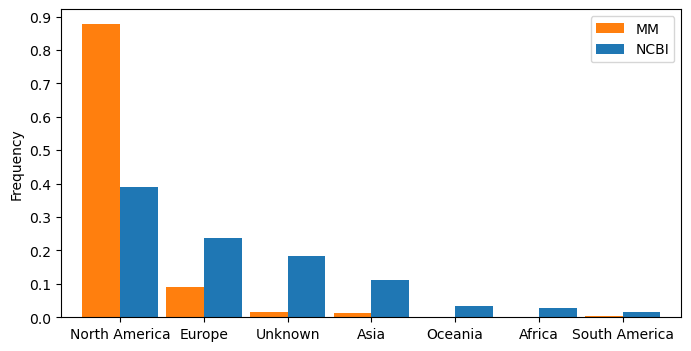

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.45
region_counts_normalized_MM.reindex_like(region_counts_normalized).plot(kind='bar', width=bar_width, position=1, rot=0, ax=ax, color='tab:orange', label='MM')
region_counts_normalized.plot(kind='bar', width=bar_width, position=0, rot=0, ax=ax, color='tab:blue', label='NCBI')
ax.set_ylabel('Frequency')
ax.set_xlabel('')
max_val = max(region_counts_normalized.max(), region_counts_normalized_MM.max())
ax.set_yticks(np.arange(0, max_val+0.1, 0.1))
ax.set_xlim(-0.7, len(region_counts_normalized)-0.3)
ax.set_xticks(np.arange(len(region_counts_normalized)))
plt.legend()
plt.savefig(os.path.join('results', 'figures', 'NCBI_vs_MM_region_distr.eps'), bbox_inches='tight', dpi=300)
plt.show()